# 4. Data Preprocessing

This notebook details the steps needed to prepare the roadway and demographic data into static and temporal features (variables). It also prepares the crash data into the target feature (number of crashes per year on a roadway segment). The Appendix to this chapter explore the distribution of the features. 

<a id='sections'></a>
**Sections**
- [**4.1 Prepare static features**](#prepare-static-features)
    - [4.1.1 PCD network static features](#PCD-network-static-features)
    - [4.1.2 IDOT network static features](#IDOT-network-static-features)
    - [4.1.3 Join PCD and IDOT roadway network features](#join-PCD-and-IDOT-roadway-network-features)
- [**4.2 Prepare temporal features**](#prepare-temporal-features)
     - [4.2.1 Temoral dara preparation](#temporal-data-preparation)
     - [4.2.2 Annual Average Daily Traffic (AADT)](#aadt)
     - [4.2.3 Heavy vehicle counts (HCV)](#hcv)
     - [4.2.4 Pavement condition (PC)](#pc)
     - [4.2.5 Population density](#pd)
     - [4.2.6 Combine all temporal features](#combine-all-temporal-features)
- [**4.3 Crash location and time (year)**](#crash-location-and-time)
     - [4.3.1 Project each crash to its road segment](#project-each-crash-to-its-road-segment)
     - [4.3.2 Summarize crashes per segment per year](#summarize-crashes-per-segment-per-year)
- [**4.4 Combine all features**](#combine-all-features)
- [**4.5 Explore data distribution**](#explore-data-distribution)

In [1]:
# import libraries
import pickle
import json
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import importlib
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import sys; sys.path.insert(0,'..')
from src.data_preprocessing import *

In [3]:
base_gis_dir  = "G:/CUUATS/Safety Forecasting Tool/"
base_file_dir = "L:/Safety Forecasting Tool/"
base_tool_dir = "L:/Safety_Crash Data Analysis/"

Work flow
<img src="..\src\Data_Preprocessing_Flowchart.png" style="width:1200px;">  

# 4.1 Prepare Static Features
<a id='prepare-static-features'></a>
[[back to top](#sections)]

## 4.1.1 PCD network static features
<a id='PCD-network-static-features'></a>
[[back to top](#sections)]

In [4]:
# Load output from Chapter 2.2.2
with open(base_file_dir+'data/interim/roadway/data_source/streets.pkl', 'rb') as f:
    streets = pickle.load(f)

In [5]:
streets_static = pcd_street_static(streets)

12967 street segments within IDOT inventory included


In [6]:
# Features included in this study
streets_static.columns

Index(['segment_id', 'geom', 'name', 'overlap', 'cross_name_start',
       'cross_name_end', 'start_intersection_id', 'end_intersection_id',
       'st_length', 'curve_ratio', 'idot_inventory', 'idot_begin_station',
       'idot_end_station', 'one_way', 'bicycle_facility_width',
       'bicycle_path_category', 'bicycle_buffer_width', 'bicycle_buffer_type',
       'bicycle_path_type', 'bicycle_approach_alignment', 'bus_trips_total',
       'crossing_aadt', 'crossing_functional_classification', 'crossing_speed',
       'functional_classification', 'intersection_control_type',
       'intersection_median_refuge', 'lane_configuration',
       'lanes_per_direction', 'max_lanes_crossed', 'parking_lane_width',
       'marked_center_line', 'posted_speed', 'railroad_crossing_type',
       'right_turn_length', 'road_sign_type', 'sidewalk_buffer_width',
       'sidewalk_condition_score', 'sidewalk_width', 'sidewalk_buffer_type',
       'total_lanes', 'in_urbanized_area', 'volume_capacity',
      

In [7]:
# A quick overview
streets_static.head()

segment_id                                               geom  \
0            1  01020000206B0D0000020000007081040554382E41D02B...   
1            2  01020000206B0D00000200000080D93DB922152F410044...   
5            6  01020000206B0D00000200000088C954E1C8912F417046...   
8            9  01020000206B0D000002000000E09C118561852F414035...   
10          11  01020000206B0D00000300000068666666D93A2F410000...   

              name overlap cross_name_start    cross_name_end  \
0     Glenshire Dr       P       Danbury Dr       W Kirby Ave   
1     Plum Tree Dr       P    Apple Tree Dr              None   
5   E Campbell Ave       P        N High St              None   
8      N Tanner St       P             None  W Letchworth Ave   
10     Schluter St       P          Park St          Clark St   

    start_intersection_id  end_intersection_id   st_length  curve_ratio  ...  \
0                    2930                 2950  185.013320     1.000027  ...   
1                     249                  250  114.421423     1.000026  ...   
5                    9237                 9236  407.218450     1.000024  ...   
8                    9233                 9225  205.961843     1.000024  ...   
10                   6787                 6782  290.782018     0.997698  ...   

   right_turn_length  road_sign_type  sidewalk_buffer_width  \
0                NaN            None                  132.0   
1                NaN            None                    NaN   
5                NaN            None                  278.0   
8                NaN            None                    NaN   
10               NaN            None                    NaN   

   sidewalk_condition_score  sidewalk_width sidewalk_buffer_type  total_lanes  \
0                      80.0            48.0           Landscaped          2.0   
1                       NaN             NaN                 None          2.0   
5                      47.0            48.0                 None          NaN   
8                      33.0            48.0                 None          NaN   
10                      NaN             NaN                 None          NaN   

   in_urbanized_area volume_capacity     overall_landuse  
0                Yes             NaN        Agricultural  
1                Yes             NaN    Heavy Industrial  
5               None             NaN  General Commercial  
8               None             NaN  General Commercial  
10              None             NaN                None  

[5 rows x 44 columns]

## 4.1.2 IDOT network static features
<a id='IDOT-network-static-features'></a>
[[back to top](#sections)]

In [8]:
# Load output from Chapter 2.2.1
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2018.pkl', 'rb') as f:
    HWY_2018 = pickle.load(f)
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2017.pkl', 'rb') as f:
    HWY_2017 = pickle.load(f)
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2016.pkl', 'rb') as f:
    HWY_2016 = pickle.load(f)
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2015.pkl', 'rb') as f:
    HWY_2015 = pickle.load(f)
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2014.pkl', 'rb') as f:
    HWY_2014= pickle.load(f)

In [9]:
# Features for study
HWY_static=HWY_2018[['INVENTORY', 'BEG_STA', 'END_STA', 'ACC_CNTL', 'I_SHD1_TYP', 'I_SHD1_WTH',
       'I_SHD2_TYP', 'I_SHD2_WTH', 'LN_WTH', 'LNS', 'MED_TYP', 'MED_WTH',
       'SURF_TYP', 'SURF_WTH', 'O_SHD1_TYP', 'O_SHD1_WTH', 'O_SHD2_TYP',
       'O_SHD2_WTH', 'OP_1_2_WAY', 'PRK_LT', 'PRK_RT', 'SURF_YR', 'FCNAME', 'JUR_TYPE', 'MPO', 'MUNI_NAME', 'NHS',
       'ROAD_NAME', 'SP_LIM', 'TRK_RT']]

## 4.1.3 Join PCD and IDOT roadway network features
<a id='join-PCD-and-IDOT-roadway-network-features'></a>
[[back to top](#sections)]

In [10]:
roadway_static=pd.merge(streets_static, HWY_static,  
                        how='left', 
                        left_on=['idot_inventory','idot_begin_station','idot_end_station'], 
                        right_on = ['INVENTORY','BEG_STA','END_STA'])

In [11]:
roadway_static.head()

segment_id                                               geom  \
0           1  01020000206B0D0000020000007081040554382E41D02B...   
1           2  01020000206B0D00000200000080D93DB922152F410044...   
2           6  01020000206B0D00000200000088C954E1C8912F417046...   
3           9  01020000206B0D000002000000E09C118561852F414035...   
4          11  01020000206B0D00000300000068666666D93A2F410000...   

             name overlap cross_name_start    cross_name_end  \
0    Glenshire Dr       P       Danbury Dr       W Kirby Ave   
1    Plum Tree Dr       P    Apple Tree Dr              None   
2  E Campbell Ave       P        N High St              None   
3     N Tanner St       P             None  W Letchworth Ave   
4     Schluter St       P          Park St          Clark St   

   start_intersection_id  end_intersection_id   st_length  curve_ratio  ...  \
0                   2930                 2950  185.013320     1.000027  ...   
1                    249                  250  114.421423     1.000026  ...   
2                   9237                 9236  407.218450     1.000024  ...   
3                   9233                 9225  205.961843     1.000024  ...   
4                   6787                 6782  290.782018     0.997698  ...   

  PRK_RT  SURF_YR                FCNAME JUR_TYPE   MPO   MUNI_NAME  NHS  \
0      0     None  Local Road or Street        9  0990        0000    0   
1      0     None  Local Road or Street        7  0990        0000    0   
2      0     1990       Major Collector        4  0000     Rantoul    0   
3      0     None  Local Road or Street        4  0000     Rantoul    0   
4      0     None  Local Road or Street        4  0000  Thomasboro    0   

      ROAD_NAME SP_LIM TRK_RT  
0  GLENSHIRE DR      0      0  
1   CRABTREE ST      0      0  
2  CAMPBELL AVE      0      0  
3     TANNER ST      0      0  
4   SCHLUTER ST      0      0  

[5 rows x 74 columns]

In [13]:
#with open('../data/interim/roadway/preprocessing/roadway_static.pkl', 'wb') as f:
#    pickle.dump(roadway_static, f)

with open(base_file_dir+'data/interim/roadway/preprocessing/roadway_static.pkl', 'rb') as f:
    roadway_static = pickle.load(f)

In [14]:
# There are missing values in the table. Table below shows share of segments with missing values.
roadway_static_nan=pd.DataFrame(roadway_static.isnull().sum())
roadway_static_nan['nan_share']=roadway_static_nan[0]/roadway_static.shape[0]*100
roadway_static_nan.sort_values(by='nan_share',ascending=False)

0   nan_share
intersection_median_refuge  12967  100.000000
bicycle_approach_alignment  12950   99.868898
right_turn_length           12836   98.989743
railroad_crossing_type      12799   98.704403
parking_lane_width          12798   98.696692
...                           ...         ...
st_length                       0    0.000000
end_intersection_id             0    0.000000
start_intersection_id           0    0.000000
overlap                         0    0.000000
segment_id                      0    0.000000

[74 rows x 2 columns]

### * Populate missing values  

The strategy of treating the missing values is shown in the table below.

|                                    |                     |                                                                | 
|------------------------------------|---------------------|----------------------------------------------------------------| 
| Columns                            | Missing value share | Strategy                                                       | 
| sub_segment_index                  | 0                   |                                                                | 
| segment_id                         | 0                   |                                                                | 
| geom                               | 0                   |                                                                | 
| name                               | 0.2                 |  Replace missing with None                                     | 
| cross_name_start                   | 7.5                 |  Replace missing with None                                     | 
| cross_name_end                     | 9.3                 |  Replace missing with None                                     | 
| start_intersection_id              | 0                   |                                                                | 
| end_intersection_id                | 0                   |                                                                | 
| st_length                          | 0                   |                                                                | 
| curve_ratio                        | 0                   |                                                                | 
| idot_inventory                     | 0                   |                                                                | 
| idot_begin_station                 | 0                   |                                                                | 
| idot_end_station                   | 0                   |                                                                | 
| one_way                            | 0                   | If a rdwy is not one-way (1), then it is a two-way street (0)  | 
| bicycle_facility_width             | 78.9                | Replace 0 with mean then replace missing with 0                | 
| bicycle_path_category              | 78.8                | Replace missing with None                  | 
| bicycle_buffer_width               | 79                  | Replace 0 with mean then replace missing with 0                | 
| bicycle_buffer_type                | 78.8                | Replace missing with None                                      | 
| bicycle_path_type                  | 78.8                | Replace missing with None                                      | 
| bicycle_approach_alignment         | 92.9                | Replace missing with None                                      | 
| bus_trips_total                    | 68.8                | Replace missing with 0                                         | 
| crossing_aadt                      | 12.6                | Replace missing with 0                                         | 
| crossing_functional_classification | 12.6                | Replace missing with current roadway functional classification | 
| crossing_speed                     | 9.3                 | Replace missing with posted speed                              | 
| functional_classification          | 1.3                 | Replace missing with local roads                               | 
| intersection_control_type          | 8.2                 | Replace blank, NA, and missing with None                       | 
| intersection_median_refuge         | 93.2                |  Remove this column                                            | 
| lane_configuration                 | 79.2                |  Replace missing with TT (through)                             | 
| lanes_per_direction                | 21.4                |  Replace missing with LNS/2, and 1                             | 
| max_lanes_crossed                  | 0.3                 |  Replace missing with 0                                        | 
| parking_lane_width                 | 91.3                |  Replace missing with 0                                        | 
| marked_center_line                 | 21.7                |  Replace missing with No                                       | 
| posted_speed                       | 3.3                 |  Replace missing with 30                                       | 
| railroad_crossing_type             | 91.5                |  Replace missing with None                                     | 
| right_turn_length                  | 92                  |  Replace missing with 0                                        | 
| road_sign_type                     | 75.3                |  Replace missing with None                                     | 
| sidewalk_buffer_width              | 22.3                |  Replace missing with 0                                        | 
| sidewalk_condition_score           | 20.7                |  Replace missing with 0                                        | 
| sidewalk_width                     | 20.7                |  Replace missing with 0                                        | 
| sidewalk_buffer_type               | 22.2                |  Replace missing with Unknown                                  | 
| total_lanes                        | 21.7                |  Replace missing with LNS, and 2                               | 
| in_urbanized_area                  | 20.2                |  Replace missing with No                                       | 
| volume_capacity                    | 46.9                |  Replace missing with 0                                        | 
| overall_landuse                    | 2                   |  Replace with most common land use of same segment_id          | 
| INVENTORY                          | 6.8                 |  Remove all rows with missing INVENTORY                        | 
| BEG_STA                            | 6.8                 |  see above                                                     | 
| END_STA                            | 6.8                 |   see above                                                    | 
| ACC_CNTL                           | 6.8                 |   see above                                                    | 
| I_SHD1_TYP                         | 6.8                 |   see above                                                    | 
| I_SHD1_WTH                         | 6.8                 |   see above                                                    | 
| I_SHD2_TYP                         | 6.8                 |   see above                                                    | 
| I_SHD2_WTH                         | 6.8                 |   see above                                                    | 
| LN_WTH                             | 6.8                 |   see above                                                    | 
| LNS                                | 6.8                 |  Remove                                                        | 
| MED_TYP                            | 6.8                 |   see above                                                    | 
| MED_WTH                            | 6.8                 |   see above                                                    | 
| SURF_TYP                           | 6.8                 |   see above                                                    | 
| SURF_WTH                           | 6.8                 |   see above                                                    | 
| O_SHD1_TYP                         | 6.8                 |   see above                                                    | 
| O_SHD1_WTH                         | 6.8                 |   see above                                                    | 
| O_SHD2_TYP                         | 6.8                 |   see above                                                    | 
| O_SHD2_WTH                         | 6.8                 |   see above                                                    | 
| OP_1_2_WAY                         | 6.8                 |   see above                                                    | 
| PRK_LT                             | 6.8                 |   see above                                                    | 
| PRK_RT                             | 6.8                 |   see above                                                    | 
| SURF_YR                            | 63.3                |  remove this column                                            | 
| FCNAME                             | 6.8                 |  see INVENTORY                                                 | 
| JUR_TYPE                           | 6.8                 |  see above                                                     | 
| MPO                                | 6.8                 |  see above                                                     | 
| MUNI_NAME                          | 6.8                 |  see above                                                     | 
| NHS                                | 6.8                 |  see above                                                     | 
| ROAD_NAME                          | 7.8                 |  remove this column                                            | 
| SP_LIM                             | 6.8                 |  remove this column                                            | 
| TRK_RT                             | 6.8                 |  see above                                                     | 


In [15]:
# Populate missing values
roadway_static_full = rdwy_static_deal_miss(roadway_static)

In [16]:
# Check again to see if there is any missing value
roadway_static_full_nan=pd.DataFrame(roadway_static_full.isnull().sum())
roadway_static_full_nan['nan_share']=roadway_static_full_nan[0]/roadway_static_full.shape[0]*100
roadway_static_full_nan.sort_values(by='nan_share',ascending=False)

0  nan_share
segment_id              0        0.0
END_STA                 0        0.0
LN_WTH                  0        0.0
I_SHD2_WTH              0        0.0
I_SHD2_TYP              0        0.0
...                    ..        ...
marked_center_line      0        0.0
posted_speed            0        0.0
railroad_crossing_type  0        0.0
right_turn_length       0        0.0
TRK_RT                  0        0.0

[69 rows x 2 columns]

In [17]:
#with open('../data/interim/roadway/preprocessing/roadway_static_full_final.pkl', 'wb') as f:
#     pickle.dump(roadway_static_full, f)

with open(base_file_dir+'data/interim/roadway/preprocessing/roadway_static_full_final.pkl', 'rb') as f:
    roadway_static_full = pickle.load(f)

In [18]:
roadway_static_full.head()

segment_id                                               geom  \
0           1  01020000206B0D0000020000007081040554382E41D02B...   
1           2  01020000206B0D00000200000080D93DB922152F410044...   
2           6  01020000206B0D00000200000088C954E1C8912F417046...   
3           9  01020000206B0D000002000000E09C118561852F414035...   
4          11  01020000206B0D00000300000068666666D93A2F410000...   

             name overlap cross_name_start    cross_name_end  \
0    Glenshire Dr       P       Danbury Dr       W Kirby Ave   
1    Plum Tree Dr       P    Apple Tree Dr                 0   
2  E Campbell Ave       P        N High St                 0   
3     N Tanner St       P                0  W Letchworth Ave   
4     Schluter St       P          Park St          Clark St   

   start_intersection_id  end_intersection_id   st_length  curve_ratio  ...  \
0                   2930                 2950  185.013320     1.000027  ...   
1                    249                  250  114.421423     1.000026  ...   
2                   9237                 9236  407.218450     1.000024  ...   
3                   9233                 9225  205.961843     1.000024  ...   
4                   6787                 6782  290.782018     0.997698  ...   

  O_SHD2_WTH  OP_1_2_WAY  PRK_LT PRK_RT                FCNAME JUR_TYPE   MPO  \
0        0.0           2       0      0  Local Road or Street        9  0990   
1        0.0           2       0      0  Local Road or Street        7  0990   
2        0.0           2       0      0       Major Collector        4  0000   
3        0.0           2       0      0  Local Road or Street        4  0000   
4        0.0           2       0      0  Local Road or Street        4  0000   

    MUNI_NAME NHS TRK_RT  
0        0000   0      0  
1        0000   0      0  
2     Rantoul   0      0  
3     Rantoul   0      0  
4  Thomasboro   0      0  

[5 rows x 69 columns]

<a id='temporal-features'></a>

# 4.2 Prepare Temporal Features
<a id='prepare-temporal-features'></a>
[[back to top](#sections)]

Get temporal features from IDOT Highway networks

## 4.2.1 Temporal data preparation
<a id='temporal-data-preparation'></a>
[[back to top](#sections)]

In [18]:
streets.columns

Index(['segment_id', 'geometry', 'bicycle_approach_alignment',
       'bicycle_buffer_width', 'bicycle_facility_width', 'BLTS_Label',
       'crossing_functional_classification', 'intersection_control_type',
       'lane_configuration', 'overall_landuse', 'railroad_crossing_type',
       'sidewalk_buffer_type', 'sidewalk_buffer_width', 'alts_score',
       'bicycle_buffer_type', 'bicycle_path_category', 'bicycle_path_type',
       'blts_score', 'bus_trips_total', 'crossing_aadt', 'crossing_speed',
       'heavy_vehicle_count', 'intersection_median_refuge',
       'max_lanes_crossed', 'pavement_condition', 'plts_score',
       'right_turn_length', 'road_sign_type', 'sidewalk_condition_score',
       'sidewalk_width', 'volume_capacity', 'Label', 'id', 'geom', 'name',
       'county_road', 'county_road_direction', 'county_highway', 'state_route',
       'us_route', 'interstate', 'private', 'one_way', 'posted_speed',
       'carto_type', 'overlap', 'street_id', 'start_intersection_id',
   

In [19]:
# Select PCD street network features that change over time
streets_temporal = streets_tmp(streets)

In [20]:
streets_temporal.head()

segment_id                                               geom  \
0            1  01020000206B0D0000020000007081040554382E41D02B...   
1            2  01020000206B0D00000200000080D93DB922152F410044...   
5            6  01020000206B0D00000200000088C954E1C8912F417046...   
8            9  01020000206B0D000002000000E09C118561852F414035...   
10          11  01020000206B0D00000300000068666666D93A2F410000...   

       idot_inventory  idot_begin_station  idot_end_station    aadt  \
0   010  70550C000000                0.08              0.22   375.0   
1   010  70531A000000                0.00              0.02     0.0   
5   010  97073 000000                0.39              0.48  1450.0   
8   010  06450 004810                0.08              0.16   150.0   
10  010  06500 005710                0.73              1.02     0.0   

   functional_classification  heavy_vehicle_count pavement_condition  
0       Local Road or Street                  NaN               None  
1       Local Road or Street                  NaN               None  
5            Major Collector                  NaN               None  
8       Local Road or Street                  NaN               None  
10      Local Road or Street                  NaN               None

In [21]:
# Load historic IDOT files
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2013.pkl', 'rb') as f:
    HWY_2013 = pickle.load(f)
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2012.pkl', 'rb') as f:
    HWY_2012 = pickle.load(f)
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2011.pkl', 'rb') as f:
    HWY_2011 = pickle.load(f)
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2010.pkl', 'rb') as f:
    HWY_2010 = pickle.load(f)
with open(base_file_dir+'data/interim/roadway/data_source/HWY_2009.pkl', 'rb') as f:
    HWY_2009 = pickle.load(f)

In [22]:
# Select IDOT network features that change over time
temporal_attri=['INVENTORY', 'BEG_STA', 'END_STA',
                'AADT','AADT_YR', 'HCV','HCV_MU_YR', 'MU_VOL', 'SU_VOL',
                'CRS_LOW', 'CRS_YR', 'DTRESS_OPP', 'FAULT_LOW', 'IRI_LOW','RUT_LOW','FCNAME']
HWY_temporal_2018=HWY_2018[temporal_attri]
HWY_temporal_2017=HWY_2017[temporal_attri]
HWY_temporal_2016=HWY_2016[temporal_attri]
HWY_temporal_2015=HWY_2015[temporal_attri]
HWY_temporal_2014=HWY_2014[temporal_attri]

temporal_his_attri=['INVENTORY', 'BEG_STA', 'END_STA',
                'AADT','AADT_YR', 'HCV','HCV_MU_YR','FCNAME']
HWY_temporal_2013=HWY_2013[temporal_his_attri]
HWY_temporal_2012=HWY_2012[temporal_his_attri]
HWY_temporal_2011=HWY_2011[temporal_his_attri]
HWY_temporal_2010=HWY_2010[temporal_his_attri]
HWY_temporal_2009=HWY_2009[temporal_his_attri]

In [23]:
# A quick view
HWY_temporal_2018.head()

INVENTORY  BEG_STA  END_STA    AADT AADT_YR  HCV HCV_MU_YR  MU_VOL  \
0  010  70068 000000     0.11     0.57   175.0    2016  0.0      0000     0.0   
1  010  03503K000990     0.00     0.27     0.0    None  0.0      0000     0.0   
2  010  70176 000000     1.85     3.11   400.0    2016  0.0      0000     0.0   
3  010  70176 000000     3.75     3.77  1200.0    2018  0.0      0000     0.0   
4  010  70176 000000     3.11     3.46  1200.0    2018  0.0      0000     0.0   

   SU_VOL  CRS_LOW CRS_YR DTRESS_OPP  FAULT_LOW  IRI_LOW  RUT_LOW  \
0     0.0      0.0   0000       None        0.0      0.0      0.0   
1     0.0      0.0   0000       None        0.0      0.0      0.0   
2     0.0      0.0   0000       None        0.0      0.0      0.0   
3     0.0      0.0   0000       None        0.0      0.0      0.0   
4     0.0      0.0   0000       None        0.0      0.0      0.0   

                 FCNAME  
0  Local Road or Street  
1  Local Road or Street  
2  Local Road or Street  
3  Local Road or Street  
4  Local Road or Street

## 4.2.2 Annual Average Daily Traffic (AADT)
<a id='aadt'></a>
[[back to top](#sections)]

### Step 1: Get roadway AADT by year

A road segment may have AADT records for certain years but not for the other years. The AADT records need to be extrapolated from the existing records.

#### * Get AADT for each year

In [24]:
HWY_temporal_2018_aadt=get_aadt(HWY_temporal_2018)
HWY_temporal_2017_aadt=get_aadt(HWY_temporal_2017)
HWY_temporal_2016_aadt=get_aadt(HWY_temporal_2016)
HWY_temporal_2015_aadt=get_aadt(HWY_temporal_2015)
HWY_temporal_2014_aadt=get_aadt(HWY_temporal_2014)
HWY_temporal_2013_aadt=get_aadt(HWY_temporal_2013)
HWY_temporal_2012_aadt=get_aadt(HWY_temporal_2012)
HWY_temporal_2011_aadt=get_aadt(HWY_temporal_2011)
HWY_temporal_2010_aadt=get_aadt(HWY_temporal_2010)
HWY_temporal_2009_aadt=get_aadt(HWY_temporal_2009)

In [25]:
# A quick view
HWY_temporal_2018_aadt.head()

INVENTORY  BEG_STA  END_STA  AADT_2018  AADT_2017  AADT_2016  \
0  010  70068 000000     0.11     0.57        NaN        NaN      175.0   
1  010  03503K000990     0.00     0.27        NaN        NaN        NaN   
2  010  70176 000000     1.85     3.11        NaN        NaN      400.0   
3  010  70176 000000     3.75     3.77     1200.0        NaN        NaN   
4  010  70176 000000     3.11     3.46     1200.0        NaN        NaN   

   AADT_2015  AADT_2014  AADT_2013  AADT_2012  AADT_2011  AADT_2010  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

   AADT_2009                FCNAME  
0        NaN  Local Road or Street  
1        NaN  Local Road or Street  
2        NaN  Local Road or Street  
3        NaN  Local Road or Street  
4        NaN  Local Road or Street

#### * Merge all AADT data by year

In [26]:
# Merge 2009~2018 aadt by ['INVENTORY','BEG_STA','END_STA']
HWY_temporal_2009_2018 = merge_all_temp_aadt(
    HWY_temporal_2018_aadt,HWY_temporal_2017_aadt,HWY_temporal_2016_aadt,HWY_temporal_2015_aadt,HWY_temporal_2014_aadt,
    HWY_temporal_2013_aadt,HWY_temporal_2012_aadt,HWY_temporal_2011_aadt,HWY_temporal_2010_aadt,HWY_temporal_2009_aadt)

In [27]:
# Example
HWY_temporal_2009_2018.head()

INVENTORY  BEG_STA  END_STA  AADT_2018  AADT_2017  AADT_2016  \
0  010  70068 000000     0.11     0.57        NaN        NaN      175.0   
1  010  03503K000990     0.00     0.27        NaN        NaN        NaN   
2  010  70176 000000     1.85     3.11        NaN        NaN      400.0   
3  010  70176 000000     3.75     3.77     1200.0        NaN      450.0   
4  010  70176 000000     3.11     3.46     1200.0        NaN      450.0   

   AADT_2015  AADT_2014  AADT_2013  AADT_2012  AADT_2011  AADT_2010  \
0        NaN        NaN        NaN        NaN      175.0        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN      150.0        NaN   
3        NaN        NaN        NaN        NaN      275.0        NaN   
4        NaN        NaN        NaN        NaN      275.0        NaN   

   AADT_2009                FCNAME  
0        NaN  Local Road or Street  
1        NaN  Local Road or Street  
2        NaN  Local Road or Street  
3        NaN  Local Road or Street  
4        NaN  Local Road or Street

In [28]:
# There are many spaces with missing values
HWY_temporal_2009_2018_nan=pd.DataFrame(HWY_temporal_2009_2018.isnull().sum())
HWY_temporal_2009_2018_nan['nan_share']=HWY_temporal_2009_2018_nan[0]/HWY_temporal_2009_2018.shape[0]*100
HWY_temporal_2009_2018_nan

0  nan_share
INVENTORY      0   0.000000
BEG_STA        0   0.000000
END_STA        0   0.000000
AADT_2018  10327  93.558616
AADT_2017   9219  83.520565
AADT_2016   6488  58.778764
AADT_2015   9121  82.632723
AADT_2014  10595  95.986592
AADT_2013   9682  87.715166
AADT_2012  10422  94.419279
AADT_2011   6476  58.670049
AADT_2010  10891  98.668237
AADT_2009  10410  94.310564
FCNAME         0   0.000000

### Step 2: Populate missing AADT data
[[back to top](#sections)]

Extrapolate missing AADT values:
* For each segment, if AADT numbers are missing for all years, get average AADT for the corresponding functional classification for each year
* For each segment, if AADT numbers are available for only one year, apply average AADT yearly percentage change for the corresponding functional classification to calculate AADT for each year
* For each segment, if AADT numbers are available for at least two years, calculate average AADT yearly percentage change for this segment between years with AADT number, and apply the percentage change to calculate AADT for the in-between years. Apply average yearly percentage change by functional classification for not-in-between years with missing AADT numbers.

#### * Calculate average AADT by functional classification for each year

In [29]:
# Notice there are big discrepencies in AADT by functional class across the years, e.g. local roads between year 2016 and 2018. 
# This is due to the number of counts used for average calculation, see cell below.
HWY_temporal_2009_2018=HWY_temporal_2009_2018.replace('Other Principal Arterial', 'Major Arterial')
aadt_fc=HWY_temporal_2009_2018.groupby(['FCNAME']).mean()
aadt_fc

BEG_STA    END_STA     AADT_2018     AADT_2017  \
FCNAME                                                                   
Interstate            11.672181  11.874214           NaN  19770.009242   
Local Road or Street   0.962962   1.283306    591.250000    556.944444   
Major Arterial         5.078422   5.163486  12480.107527  12085.930048   
Major Collector        4.329947   4.582477   2626.106195   3969.032258   
Minor Arterial         3.771671   3.880829  10275.285171   6447.373950   
Minor Collector        0.953895   1.224737   1184.375000           NaN   

                         AADT_2016     AADT_2015     AADT_2014     AADT_2013  \
FCNAME                                                                         
Interstate                     NaN  18647.183099           NaN  18281.894737   
Local Road or Street    557.001771   1883.333333    259.523810           NaN   
Major Arterial        12166.700820  11019.358766  15327.067669  13162.736842   
Major Collector        2620.763889   3859.808612   1824.342105   4092.920354   
Minor Arterial         8324.651458   7319.931271   8635.950413   6275.773196   
Minor Collector        1418.575419   1825.000000    803.125000   3100.000000   

                         AADT_2012     AADT_2011     AADT_2010     AADT_2009  
FCNAME                                                                        
Interstate                     NaN  18861.783854           NaN  19264.347826  
Local Road or Street   1171.875000    608.634992    503.333333    461.363636  
Major Arterial        13205.369128  10653.195489  17074.193548  13758.715596  
Major Collector        2699.878049   2949.441624   1454.069767   3536.734694  
Minor Arterial        11719.703390   8238.329161   8207.142857   5117.982456  
Minor Collector         695.000000   1816.726619    600.000000           NaN

#### * Interpolate/extrapolate missing AADT (assuming linear trend)

In [30]:
HWY_temporal_2009_2018.groupby(['FCNAME']).count()

INVENTORY  BEG_STA  END_STA  AADT_2018  AADT_2017  \
FCNAME                                                                    
Interstate                  541      541      541          0        541   
Local Road or Street       6657     6657     6657         20         18   
Major Arterial              938      938      938        186        629   
Major Collector            1324     1324     1324        226        155   
Minor Arterial             1388     1388     1388        263        476   
Minor Collector             190      190      190         16          0   

                      AADT_2016  AADT_2015  AADT_2014  AADT_2013  AADT_2012  \
FCNAME                                                                        
Interstate                    0        497          0        475          0   
Local Road or Street       2258          9         21          0         16   
Major Arterial              244        616        133        475        149   
Major Collector            1080        209        152        113        205   
Minor Arterial              789        582        121        291        236   
Minor Collector             179          4         16          2         10   

                      AADT_2011  AADT_2010  AADT_2009  
FCNAME                                                 
Interstate                  384          0        345  
Local Road or Street       1989          6         11  
Major Arterial              266         31        109  
Major Collector             985         86         49  
Minor Arterial              799         14        114  
Minor Collector             139         10          0

Get number of segments with AADT count by functional classification. Notice AADT were mainly collected for:
* [0] Interstates in 2017, 2015, 2013, 2011, 2009. Average AADT of these years are closer.
* [1] Local Roads or streets: 2016, 2011
* [2] Major Arterial: 2017, 2015, 2013, 2011
* [3] Major Collector: 2016, 2011
* [4] Minor Arterial: 2016, 2015, 2011	
* [5] Minor Collector: 2016, 2011  
   
Therefore, the next step is to interpolate/extrapolate (assuming linear trend) AADT for the rest of the years by functional classification using AADT numbers of the years with the most counts. 

In [31]:
# Assume linear trend between AADT and year
from sklearn.linear_model import LinearRegression
aadt_regsr=LinearRegression()

In [32]:
aadt_fc=update_aadt_fc(aadt_regsr,aadt_fc,aadt_train_years,aadt_train_index,aadt_predict_years,aadt_predict_index,0)
aadt_fc=update_aadt_fc(aadt_regsr,aadt_fc,aadt_train_years,aadt_train_index,aadt_predict_years,aadt_predict_index,1)
aadt_fc=update_aadt_fc(aadt_regsr,aadt_fc,aadt_train_years,aadt_train_index,aadt_predict_years,aadt_predict_index,2)
aadt_fc=update_aadt_fc(aadt_regsr,aadt_fc,aadt_train_years,aadt_train_index,aadt_predict_years,aadt_predict_index,3)
aadt_fc=update_aadt_fc(aadt_regsr,aadt_fc,aadt_train_years,aadt_train_index,aadt_predict_years,aadt_predict_index,4)
aadt_fc=update_aadt_fc(aadt_regsr,aadt_fc,aadt_train_years,aadt_train_index,aadt_predict_years,aadt_predict_index,5)

In [33]:
aadt_fc

BEG_STA    END_STA     AADT_2018     AADT_2017  \
FCNAME                                                                   
Interstate            11.672181  11.874214  19164.224271  19770.009242   
Local Road or Street   0.962962   1.283306    536.348483    546.675127   
Major Arterial         5.078422   5.163486  12161.270406  12085.930048   
Major Collector        4.329947   4.582477   2489.292795   2555.028342   
Minor Arterial         3.771671   3.880829   7747.898259   7801.166352   
Minor Collector        0.953895   1.224737   1259.314939   1338.945179   

                         AADT_2016     AADT_2015     AADT_2014     AADT_2013  \
FCNAME                                                                         
Interstate            19084.552063  18647.183099  19004.879855  18281.894737   
Local Road or Street    557.001771    567.328416    577.655060    587.981704   
Major Arterial        11945.787846  11019.358766  11730.305286  13162.736842   
Major Collector        2620.763889   2686.499436   2752.234983   2817.970530   
Minor Arterial         8324.651458   7319.931271   7960.970630   8014.238723   
Minor Collector        1418.575419   1498.205659   1577.835899   1657.466139   

                         AADT_2012     AADT_2011     AADT_2010     AADT_2009  
FCNAME                                                                        
Interstate            18925.207648  18861.783854  18845.535440  19264.347826  
Local Road or Street    598.308348    608.634992    618.961637    629.288281  
Major Arterial        11514.822726  10653.195489  11299.340166  11191.598886  
Major Collector        2883.706077   2949.441624   3015.177171   3080.912719  
Minor Arterial         8067.506816   8238.329161   8174.043001   8227.311094  
Minor Collector        1737.096379   1816.726619   1896.356859   1975.987099

#### * Calculate percentage change for different base year

In [34]:
# Calculate percentage change assuming different years as the base year
aadt_fc_pt_year = aadt_fc_pct(aadt_fc)

In [35]:
# Example
aadt_fc_pt_year.get(2018)

BEG_STA    END_STA  AADT_2018  AADT_2017  AADT_2016  \
FCNAME                                                                        
Interstate            11.672181  11.874214        0.0   0.031610  -0.004157   
Local Road or Street   0.962962   1.283306        0.0   0.019254   0.038507   
Major Arterial         5.078422   5.163486        0.0  -0.006195  -0.017719   
Major Collector        4.329947   4.582477        0.0   0.026407   0.052815   
Minor Arterial         3.771671   3.880829        0.0   0.006875   0.074440   
Minor Collector        0.953895   1.224737        0.0   0.063233   0.126466   

                      AADT_2015  AADT_2014  AADT_2013  AADT_2012  AADT_2011  \
FCNAME                                                                        
Interstate            -0.026979  -0.008315  -0.046040  -0.012472  -0.015782   
Local Road or Street   0.057761   0.077014   0.096268   0.115522   0.134775   
Major Arterial        -0.093897  -0.035438   0.082349  -0.053156  -0.124006   
Major Collector        0.079222   0.105629   0.132037   0.158444   0.184851   
Minor Arterial        -0.055237   0.027501   0.034376   0.041251   0.063299   
Minor Collector        0.189699   0.252932   0.316165   0.379398   0.442631   

                      AADT_2010  AADT_2009  
FCNAME                                      
Interstate            -0.016629   0.005225  
Local Road or Street   0.154029   0.173282  
Major Arterial        -0.070875  -0.079734  
Major Collector        0.211259   0.237666  
Minor Arterial         0.055001   0.061877  
Minor Collector        0.505864   0.569097

#### * Update missing aadt values basing on average aadt or percent change

In [36]:
HWY_temporal_2009_2018_copy=HWY_temporal_2009_2018[['BEG_STA','END_STA','AADT_2018','AADT_2017',
                                                       'AADT_2016','AADT_2015','AADT_2014','AADT_2013',
                                                        'AADT_2012','AADT_2011','AADT_2010','AADT_2009',
                                                        'INVENTORY','FCNAME',]].copy()

In [37]:
# Before updating
HWY_temporal_2009_2018_before_nan=pd.DataFrame(HWY_temporal_2009_2018_copy.isnull().sum())
HWY_temporal_2009_2018_before_nan['nan_share']=HWY_temporal_2009_2018_before_nan[0]/HWY_temporal_2009_2018_copy.shape[0]*100
HWY_temporal_2009_2018_before_nan

0  nan_share
BEG_STA        0   0.000000
END_STA        0   0.000000
AADT_2018  10327  93.558616
AADT_2017   9219  83.520565
AADT_2016   6488  58.778764
AADT_2015   9121  82.632723
AADT_2014  10595  95.986592
AADT_2013   9682  87.715166
AADT_2012  10422  94.419279
AADT_2011   6476  58.670049
AADT_2010  10891  98.668237
AADT_2009  10410  94.310564
INVENTORY      0   0.000000
FCNAME         0   0.000000

In [38]:
# Update the aadt numbers for the segment database, based on years with AADT numbers available and functional classfication
HWY_temporal_2009_2018_copy_update = upd_miss_aadt_row(aadt_fc,aadt_fc_pt_year,HWY_temporal_2009_2018_copy)

In [39]:
# After updating
HWY_temporal_2009_2018_copy_update_nan=pd.DataFrame(HWY_temporal_2009_2018_copy_update.isnull().sum())
HWY_temporal_2009_2018_copy_update_nan['nan_share']=HWY_temporal_2009_2018_copy_update_nan[0]/HWY_temporal_2009_2018_copy.shape[0]*100
HWY_temporal_2009_2018_copy_update_nan

0  nan_share
BEG_STA    0        0.0
END_STA    0        0.0
AADT_2018  0        0.0
AADT_2017  0        0.0
AADT_2016  0        0.0
AADT_2015  0        0.0
AADT_2014  0        0.0
AADT_2013  0        0.0
AADT_2012  0        0.0
AADT_2011  0        0.0
AADT_2010  0        0.0
AADT_2009  0        0.0
INVENTORY  0        0.0
FCNAME     0        0.0

### Step 3: Combine IDOT HWY network AADT and PCD streets AADT by segments

In [40]:
roadway_temporal_2009_2018 = cmb_tmp_HWY_sts_aadt(HWY_temporal_2009_2018_copy_update,streets_temporal)

In [41]:
roadway_temporal_2009_2018.shape

(12972, 13)

In [42]:
# Check missing values
roadway_temporal_2009_2018_nan=pd.DataFrame(roadway_temporal_2009_2018.isnull().sum())
roadway_temporal_2009_2018_nan['nan_share']=roadway_temporal_2009_2018_nan[0]/roadway_temporal_2009_2018.shape[0]*100
roadway_temporal_2009_2018_nan
## AADT_20XX is aadt from IDOT HWY network dataset, aadt is from PCD streets network dataset

0  nan_share
segment_id                   0   0.000000
AADT_2018                  819   6.313599
AADT_2017                  819   6.313599
AADT_2016                  819   6.313599
AADT_2015                  819   6.313599
AADT_2014                  819   6.313599
AADT_2013                  819   6.313599
AADT_2012                  819   6.313599
AADT_2011                  819   6.313599
AADT_2010                  819   6.313599
AADT_2009                  819   6.313599
aadt                       473   3.646315
functional_classification  154   1.187172

In [43]:
# Select years targeted for training data (2014~2018)
roadway_temporal_2014_2018=roadway_temporal_2009_2018[['segment_id',
             'AADT_2018','AADT_2017','AADT_2016','AADT_2015','AADT_2014',
             'aadt','functional_classification']]

In [44]:
#with open('../data/interim/roadway/preprocessing/roadway_temporal_2014_2018_final.pkl', 'wb') as f:
#     pickle.dump(roadway_temporal_2014_2018, f)

with open(base_file_dir+'data/interim/roadway/preprocessing/roadway_temporal_2014_2018_final.pkl', 'rb') as f:
    roadway_temporal_2014_2018 = pickle.load(f)

In [45]:
roadway_temporal_2014_2018.describe()

segment_id     AADT_2018     AADT_2017     AADT_2016     AADT_2015  \
count  12972.000000  12153.000000  12153.000000  12153.000000  12153.000000   
mean    8228.679232   1822.564957   1851.607580   1900.762460   1835.587320   
std     4597.391824   4222.799242   4296.353968   4380.441739   4220.232758   
min        1.000000     24.073015      0.000000     25.000000     20.000000   
25%     4230.750000    536.348483    546.675127    557.001771    567.328416   
50%     8436.500000    536.348483    546.675127    557.001771    567.328416   
75%    12086.250000    536.348483    546.675127    557.001771    567.328416   
max    16090.000000  61166.514222  63100.000000  63150.000000  63000.000000   

          AADT_2014          aadt  
count  12153.000000  12499.000000  
mean    1826.447584   1605.409233  
std     4255.802163   4426.335381  
min      -40.000000      0.000000  
25%      577.655060      0.000000  
50%      577.655060     75.000000  
75%      577.655060    850.000000  
max    65450.000000  63000.000000

## 4.2.3 Heavy vehicle counts (HCV)
<a id='hcv'></a>
[[back to top](#sections)]

### Step 1: Get HCV by year

#### * Get HCV for each year

In [46]:
HWY_temporal_2018_hcv=get_hcv(HWY_temporal_2018)
HWY_temporal_2017_hcv=get_hcv(HWY_temporal_2017)
HWY_temporal_2016_hcv=get_hcv(HWY_temporal_2016)
HWY_temporal_2015_hcv=get_hcv(HWY_temporal_2015)
HWY_temporal_2014_hcv=get_hcv(HWY_temporal_2014)
HWY_temporal_2013_hcv=get_hcv(HWY_temporal_2013)
HWY_temporal_2012_hcv=get_hcv(HWY_temporal_2012)
HWY_temporal_2011_hcv=get_hcv(HWY_temporal_2011)
HWY_temporal_2010_hcv=get_hcv(HWY_temporal_2010)
HWY_temporal_2009_hcv=get_hcv(HWY_temporal_2009)

#### * Merge all HCV data by year

In [47]:
HCV_temporal_2009_2018 = merge_all_temp_hcv(
    HWY_temporal_2018_hcv,HWY_temporal_2017_hcv,HWY_temporal_2016_hcv,HWY_temporal_2015_hcv,HWY_temporal_2014_hcv,
    HWY_temporal_2013_hcv,HWY_temporal_2012_hcv,HWY_temporal_2011_hcv,HWY_temporal_2010_hcv,HWY_temporal_2009_hcv)

In [48]:
HCV_temporal_2009_2018.head()

INVENTORY  BEG_STA  END_STA  HCV_2018  HCV_2017  HCV_2016  \
0  010  70068 000000     0.11     0.57       NaN       NaN       NaN   
1  010  03503K000990     0.00     0.27       NaN       NaN       NaN   
2  010  70176 000000     1.85     3.11       NaN       NaN       NaN   
3  010  70176 000000     3.75     3.77       NaN       NaN       NaN   
4  010  70176 000000     3.11     3.46       NaN       NaN       NaN   

   HCV_2015  HCV_2014  HCV_2013  HCV_2012  HCV_2011  HCV_2010  HCV_2009  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

                 FCNAME  
0  Local Road or Street  
1  Local Road or Street  
2  Local Road or Street  
3  Local Road or Street  
4  Local Road or Street

In [49]:
HCV_temporal_2009_2018_nan=pd.DataFrame(HCV_temporal_2009_2018.isnull().sum())
HCV_temporal_2009_2018_nan['nan_share']=HCV_temporal_2009_2018_nan[0]/HCV_temporal_2009_2018.shape[0]*100
HCV_temporal_2009_2018_nan

0   nan_share
INVENTORY      0    0.000000
BEG_STA        0    0.000000
END_STA        0    0.000000
HCV_2018   11011   99.755390
HCV_2017    9469   85.785468
HCV_2016   11038  100.000000
HCV_2015    9638   87.316543
HCV_2014   11003   99.682914
HCV_2013    9842   89.164704
HCV_2012   11038  100.000000
HCV_2011   10440   94.582352
HCV_2010   11038  100.000000
HCV_2009   10512   95.234644
FCNAME         0    0.000000

### Step 2: Populate missing HCV data
[[back to top](#sections)]

Extrapolate missing HCV values:
* For each segment, if HCV numbers are missing for all years,pass
* For each segment, if HCV numbers are available for only one year, apply average HCV yearly percentage change for the corresponding functional classification to calculate HCV for each year
* For each segment, if HCV numbers are available for at least two years, calculate average HCV yearly percentage change for this segment between years with HCV number, and apply the percentage change to calculate HCV for the in-between years. Apply average yearly percentage change by functional classification for not-in-between years with missing HCV numbers.

#### * Calculate average HCV by functional classification for each year

In [50]:
# Calculate average HCV by functional classification for each year
# Notice there are big discrepencies in AADT by functional class across the years, e.g. local roads between year 2016 and 2018. 
# This is due to the number of counts used for average calculation, see cell below.
# Use HWY_temporal_2009_2018 instead of roadway_temporal_2009_2018,
#   because segments in roadway_temporal_2009_2018 were split in small sub-segments making average AADT by functional classification skewed.
HCV_temporal_2009_2018=HCV_temporal_2009_2018.replace('Other Principal Arterial', 'Major Arterial')
hcv_fc=HCV_temporal_2009_2018.groupby(['FCNAME']).mean()
hcv_fc

BEG_STA    END_STA    HCV_2018     HCV_2017  HCV_2016  \
FCNAME                                                                          
Interstate            11.672181  11.874214         NaN  7208.510638       NaN   
Local Road or Street   0.962962   1.283306         NaN          NaN       NaN   
Major Arterial         5.078422   5.163486         NaN   701.875994       NaN   
Major Collector        4.329947   4.582477         NaN   300.857143       NaN   
Minor Arterial         3.771671   3.880829  417.407407   534.693396       NaN   
Minor Collector        0.953895   1.224737         NaN          NaN       NaN   

                         HCV_2015  HCV_2014     HCV_2013  HCV_2012  \
FCNAME                                                               
Interstate            6324.096386       NaN  6128.987730       NaN   
Local Road or Street          NaN       NaN          NaN       NaN   
Major Arterial         682.132743     373.0   826.439232       NaN   
Major Collector        231.487603       NaN   296.814159       NaN   
Minor Arterial         443.193717     191.6   572.500000       NaN   
Minor Collector               NaN       NaN          NaN       NaN   

                         HCV_2011  HCV_2010     HCV_2009  
FCNAME                                                    
Interstate            5385.104530       NaN  5658.867925  
Local Road or Street          NaN       NaN          NaN  
Major Arterial         725.611940       NaN   790.366972  
Major Collector        206.057692       NaN   180.384615  
Minor Arterial         454.312000       NaN   353.407080  
Minor Collector               NaN       NaN          NaN

#### * Interpolate/extrapolate missing HCV (assuming linear trend)

In [51]:
HCV_temporal_2009_2018.groupby(['FCNAME']).count()

INVENTORY  BEG_STA  END_STA  HCV_2018  HCV_2017  \
FCNAME                                                                  
Interstate                  541      541      541         0       376   
Local Road or Street       6657     6657     6657         0         0   
Major Arterial              938      938      938         0       629   
Major Collector            1324     1324     1324         0       140   
Minor Arterial             1388     1388     1388        27       424   
Minor Collector             190      190      190         0         0   

                      HCV_2016  HCV_2015  HCV_2014  HCV_2013  HCV_2012  \
FCNAME                                                                   
Interstate                   0       332         0       326         0   
Local Road or Street         0         0         0         0         0   
Major Arterial               0       565        10       469         0   
Major Collector              0       121         0       113         0   
Minor Arterial               0       382        25       288         0   
Minor Collector              0         0         0         0         0   

                      HCV_2011  HCV_2010  HCV_2009  
FCNAME                                              
Interstate                 287         0       265  
Local Road or Street         0         0         0  
Major Arterial             134         0       109  
Major Collector             52         0        39  
Minor Arterial             125         0       113  
Minor Collector              0         0         0

Update average HCV by functional class for each year.  
Get number of segments with HCV count by functional classification. Notice HCV were mainly collected for:
* [0]Interstates in 2017, 2015, 2013, 2011, 2009. 
* [1]Local Road or Street: No data
* [2]Major Arterial: 2017, 2015, 2013
* [3]Major Collector: 2017, 2015, 2013
* [4]Minor Arterial: 2017, 2015, 2013
* [5]Minor Collector: No data

   
Therefore, the next step is to extrapolate (assuming linear trend) HCV for the rest of the years by functional classification using HCV numbers of the years with the most counts. 

For minor collector and local roads, apply a **percentage** of AADT. 

#### * Calculate HCV percentage change for different base year

In [52]:
# Assume linear trend between AADT and year
from sklearn.linear_model import LinearRegression
hcv_regsr=LinearRegression()

In [53]:
hcv_fc=update_hcv_fc(hcv_regsr,hcv_fc,hcv_predict_years,hcv_predict_index,hcv_train_years,hcv_train_index,0)
hcv_fc=update_hcv_fc(hcv_regsr,hcv_fc,hcv_predict_years,hcv_predict_index,hcv_train_years,hcv_train_index,2)
hcv_fc=update_hcv_fc(hcv_regsr,hcv_fc,hcv_predict_years,hcv_predict_index,hcv_train_years,hcv_train_index,3)
hcv_fc=update_hcv_fc(hcv_regsr,hcv_fc,hcv_predict_years,hcv_predict_index,hcv_train_years,hcv_train_index,4)

In [54]:
hcv_fc

BEG_STA    END_STA     HCV_2018     HCV_2017  \
FCNAME                                                                 
Interstate            11.672181  11.874214  7150.682762  7208.510638   
Local Road or Street   0.962962   1.283306          NaN          NaN   
Major Arterial         5.078422   5.163486   643.393561   701.875994   
Major Collector        4.329947   4.582477   279.418539   300.857143   
Minor Arterial         3.771671   3.880829   488.440752   534.693396   
Minor Collector        0.953895   1.224737          NaN          NaN   

                         HCV_2016     HCV_2015     HCV_2014     HCV_2013  \
FCNAME                                                                     
Interstate            6746.855034  6324.096386  6343.027306  6128.987730   
Local Road or Street          NaN          NaN          NaN          NaN   
Major Arterial         705.675180   682.132743   767.956799   826.439232   
Major Collector        277.397048   231.487603   275.375556   296.814159   
Minor Arterial         507.344054   443.193717   526.247355   572.500000   
Minor Collector               NaN          NaN          NaN          NaN   

                         HCV_2012     HCV_2011     HCV_2010     HCV_2009  
FCNAME                                                                    
Interstate            5939.199577  5385.104530  5535.371849  5658.867925  
Local Road or Street          NaN          NaN          NaN          NaN  
Major Arterial         830.238419   861.379229   892.520038   923.660848  
Major Collector        273.354064   272.343318   271.332572   270.321826  
Minor Arterial         545.150657   554.602308   564.053959   573.505610  
Minor Collector               NaN          NaN          NaN          NaN

In [55]:
# Take a look at existing true values
HV_prop = pd.DataFrame(hcv_fc[['HCV_2018', 'HCV_2017', 'HCV_2016', 'HCV_2015','HCV_2014', 
                     'HCV_2013', 'HCV_2012', 'HCV_2011', 'HCV_2010', 'HCV_2009']].values/aadt_fc[['AADT_2018', 'AADT_2017', 'AADT_2016','AADT_2015', 'AADT_2014', 
                                                                                                  'AADT_2013', 'AADT_2012', 'AADT_2011','AADT_2010', 'AADT_2009']].values, index = hcv_fc.index)
HV_prop

0         1         2         3         4  \
FCNAME                                                                   
Interstate            0.373127  0.364618  0.353524  0.339145  0.333758   
Local Road or Street       NaN       NaN       NaN       NaN       NaN   
Major Arterial        0.052905  0.058074  0.059073  0.061903  0.065468   
Major Collector       0.112248  0.117751  0.105846  0.086167  0.100055   
Minor Arterial        0.063042  0.068540  0.060945  0.060546  0.066103   
Minor Collector            NaN       NaN       NaN       NaN       NaN   

                             5         6         7         8         9  
FCNAME                                                                  
Interstate            0.335249  0.313825  0.285503  0.293723  0.293748  
Local Road or Street       NaN       NaN       NaN       NaN       NaN  
Major Arterial        0.062786  0.072102  0.080856  0.078989  0.082532  
Major Collector       0.105329  0.094793  0.092337  0.089989  0.087741  
Minor Arterial        0.071435  0.067574  0.067320  0.069006  0.069708  
Minor Collector            NaN       NaN       NaN       NaN       NaN

#### * For minor collector and local roads, apply a percentage of AADT
Reference: [IDOT ADT Counts GIS Application](http://www.gettingaroundillinois.com/gai.htm?mt=aadt)

- Local Road or Street: Assuming heavy vehicles percentage is 5%
- Minor Collector: Assuming heavy vehicles percentage is 7%

Caution: This is just an assumption made for the purpose of filling in missing values, and it's an average value. The heavy vehicle counts varies by location. Field work is needed for sites with many heavy vehicles.

In [56]:
# Apply the assumption of heavy vehicle proportion 
hcv_fc.loc['Local Road or Street',:] = aadt_fc.loc['Local Road or Street',:].values*0.05
hcv_fc.loc['Minor Collector',:] = aadt_fc.loc['Minor Collector',:].values*0.07

In [57]:
hcv_fc

BEG_STA    END_STA     HCV_2018     HCV_2017  \
FCNAME                                                                 
Interstate            11.672181  11.874214  7150.682762  7208.510638   
Local Road or Street   0.048148   0.064165    26.817424    27.333756   
Major Arterial         5.078422   5.163486   643.393561   701.875994   
Major Collector        4.329947   4.582477   279.418539   300.857143   
Minor Arterial         3.771671   3.880829   488.440752   534.693396   
Minor Collector        0.066773   0.085732    88.152046    93.726163   

                         HCV_2016     HCV_2015     HCV_2014     HCV_2013  \
FCNAME                                                                     
Interstate            6746.855034  6324.096386  6343.027306  6128.987730   
Local Road or Street    27.850089    28.366421    28.882753    29.399085   
Major Arterial         705.675180   682.132743   767.956799   826.439232   
Major Collector        277.397048   231.487603   275.375556   296.814159   
Minor Arterial         507.344054   443.193717   526.247355   572.500000   
Minor Collector         99.300279   104.874396   110.448513   116.022630   

                         HCV_2012     HCV_2011     HCV_2010     HCV_2009  
FCNAME                                                                    
Interstate            5939.199577  5385.104530  5535.371849  5658.867925  
Local Road or Street    29.915417    30.431750    30.948082    31.464414  
Major Arterial         830.238419   861.379229   892.520038   923.660848  
Major Collector        273.354064   272.343318   271.332572   270.321826  
Minor Arterial         545.150657   554.602308   564.053959   573.505610  
Minor Collector        121.596747   127.170863   132.744980   138.319097

In [58]:
hcv_fc_pt_year = hcv_fc_pct(hcv_fc)

In [59]:
# Example
hcv_fc_pt_year.get(2018)

BEG_STA    END_STA  HCV_2018  HCV_2017  HCV_2016  \
FCNAME                                                                     
Interstate            11.672181  11.874214       0.0  0.008087 -0.056474   
Local Road or Street   0.048148   0.064165       0.0  0.019254  0.038507   
Major Arterial         5.078422   5.163486       0.0  0.090897  0.096802   
Major Collector        4.329947   4.582477       0.0  0.076726 -0.007235   
Minor Arterial         3.771671   3.880829       0.0  0.094694  0.038701   
Minor Collector        0.066773   0.085732       0.0  0.063233  0.126466   

                      HCV_2015  HCV_2014  HCV_2013  HCV_2012  HCV_2011  \
FCNAME                                                                   
Interstate           -0.115595 -0.112948 -0.142881 -0.169422 -0.246910   
Local Road or Street  0.057761  0.077014  0.096268  0.115522  0.134775   
Major Arterial        0.060211  0.193603  0.284500  0.290405  0.338806   
Major Collector      -0.171538 -0.014469  0.062256 -0.021704 -0.025321   
Minor Arterial       -0.092636  0.077403  0.172097  0.116104  0.135455   
Minor Collector       0.189699  0.252932  0.316165  0.379398  0.442631   

                      HCV_2010  HCV_2009  
FCNAME                                    
Interstate           -0.225896 -0.208626  
Local Road or Street  0.154029  0.173282  
Major Arterial        0.387207  0.435608  
Major Collector      -0.028939 -0.032556  
Minor Arterial        0.154805  0.174156  
Minor Collector       0.505864  0.569097

In [60]:
HCV_temporal_2009_2018_copy=HCV_temporal_2009_2018[['BEG_STA','END_STA','HCV_2018','HCV_2017',
                                                        'HCV_2016','HCV_2015','HCV_2014','HCV_2013',
                                                        'HCV_2012','HCV_2011','HCV_2010','HCV_2009',
                                                        'INVENTORY','FCNAME',]].copy()

In [61]:
HCV_temporal_2009_2018_copy.shape

(11038, 14)

In [62]:
HCV_temporal_2009_2018_copy_nan=pd.DataFrame(HCV_temporal_2009_2018_copy.isnull().sum())
HCV_temporal_2009_2018_copy_nan['nan_share']=HCV_temporal_2009_2018_copy_nan[0]/HCV_temporal_2009_2018_copy.shape[0]*100
HCV_temporal_2009_2018_copy_nan

0   nan_share
BEG_STA        0    0.000000
END_STA        0    0.000000
HCV_2018   11011   99.755390
HCV_2017    9469   85.785468
HCV_2016   11038  100.000000
HCV_2015    9638   87.316543
HCV_2014   11003   99.682914
HCV_2013    9842   89.164704
HCV_2012   11038  100.000000
HCV_2011   10440   94.582352
HCV_2010   11038  100.000000
HCV_2009   10512   95.234644
INVENTORY      0    0.000000
FCNAME         0    0.000000

In [63]:
HCV_temporal_2009_2018_copy_update=upd_miss_hcv_row(HCV_temporal_2009_2018_copy,hcv_fc,hcv_fc_pt_year)

In [64]:
HCV_temporal_2009_2018_copy_nan=pd.DataFrame(HCV_temporal_2009_2018_copy.isnull().sum())
HCV_temporal_2009_2018_copy_nan['nan_share']=HCV_temporal_2009_2018_copy_nan[0]/HCV_temporal_2009_2018_copy.shape[0]*100
HCV_temporal_2009_2018_copy_nan

0  nan_share
BEG_STA       0   0.000000
END_STA       0   0.000000
HCV_2018   9614  87.099112
HCV_2017   9614  87.099112
HCV_2016   9614  87.099112
HCV_2015   9614  87.099112
HCV_2014   9614  87.099112
HCV_2013   9614  87.099112
HCV_2012   9614  87.099112
HCV_2011   9614  87.099112
HCV_2010   9614  87.099112
HCV_2009   9614  87.099112
INVENTORY     0   0.000000
FCNAME        0   0.000000

### Step 3: Combine IDOT HWY network HCV and PCD streets HCV by segments

In [65]:
hcv_temporal_2009_2018=cmb_tmp_HCV_sts_hcv(HCV_temporal_2009_2018_copy_update,streets_temporal)

In [66]:
hcv_temporal_2009_2018_nan=pd.DataFrame(hcv_temporal_2009_2018.isnull().sum())
hcv_temporal_2009_2018_nan['nan_share']=hcv_temporal_2009_2018_nan[0]/hcv_temporal_2009_2018.shape[0]*100
hcv_temporal_2009_2018_nan

0  nan_share
segment_id                     0   0.000000
HCV_2018                   12398  95.575085
HCV_2017                   12398  95.575085
HCV_2016                   12398  95.575085
HCV_2015                   12398  95.575085
HCV_2014                   12398  95.575085
HCV_2013                   12398  95.575085
HCV_2012                   12398  95.575085
HCV_2011                   12398  95.575085
HCV_2010                   12398  95.575085
HCV_2009                   12398  95.575085
functional_classification    154   1.187172

In [67]:
hcv_temporal_2014_2018=hcv_temporal_2009_2018[['segment_id',
             'HCV_2018','HCV_2017','HCV_2016','HCV_2015','HCV_2014',
             'functional_classification']]

In [68]:
#with open('../data/interim/roadway/preprocessing/hcv_temporal_2014_2018_final.pkl', 'wb') as f:
#     pickle.dump(hcv_temporal_2014_2018, f)
        
with open(base_file_dir+'data/interim/roadway/preprocessing/hcv_temporal_2014_2018_final.pkl', 'rb') as f:
    hcv_temporal_2014_2018 = pickle.load(f)

In [69]:
hcv_temporal_2014_2018.tail()

segment_id    HCV_2018  HCV_2017  HCV_2016  HCV_2015  HCV_2014  \
12967       16079         NaN       NaN       NaN       NaN       NaN   
12968       16080         NaN       NaN       NaN       NaN       NaN   
12969       16084         NaN       NaN       NaN       NaN       NaN   
12970       16087         NaN       NaN       NaN       NaN       NaN   
12971       16090  311.670171     340.0     270.0     480.0     470.0   

      functional_classification  
12967      Local Road or Street  
12968      Local Road or Street  
12969      Local Road or Street  
12970      Local Road or Street  
12971            Major Arterial

In [70]:
hcv_temporal_2014_2018.describe()

segment_id      HCV_2018      HCV_2017      HCV_2016     HCV_2015  \
count  12972.000000    574.000000    574.000000    574.000000   574.000000   
mean    8228.679232   2051.857879   2104.416376   2211.127178  1890.994774   
std     4597.391824   2908.051957   2914.233808   3064.725544  2642.244318   
min        1.000000    120.736406    130.000000    102.500000   100.000000   
25%     4230.750000    368.962481    425.000000    405.000000   340.000000   
50%     8436.500000    650.840650    710.000000    706.250000   645.000000   
75%    12086.250000    962.510821   1050.000000   1267.000000  1150.000000   
max    16090.000000  10366.168355  10450.000000  11037.500000  9275.000000   

          HCV_2014  
count   574.000000  
mean   1885.847460  
std    2721.123968  
min    -172.500000  
25%     295.000000  
50%     625.000000  
75%    1209.375000  
max    9700.000000

## 4.2.4 Pavement condition
<a id='pc'></a>
[[back to top](#sections)]

### 4.2.4.1 CRS

### Step 1: Prepare crs data

#### * Get crs for each year

In [71]:
HWY_temporal_2018_crs=get_crs(HWY_temporal_2018)
HWY_temporal_2017_crs=get_crs(HWY_temporal_2017)
HWY_temporal_2016_crs=get_crs(HWY_temporal_2016)
HWY_temporal_2015_crs=get_crs(HWY_temporal_2015)
HWY_temporal_2014_crs=get_crs(HWY_temporal_2014)

#### * Merge all crs data and add pavement_condition from PCD streets

In [72]:
crs_temporal_2014_2018 = merge_all_temp_crs(streets_temporal,HWY_temporal_2018_crs,HWY_temporal_2017_crs,
                                            HWY_temporal_2016_crs,HWY_temporal_2015_crs,HWY_temporal_2014_crs)

In [73]:
crs_temporal_2014_2018.columns

Index(['segment_id', 'CRS_2014', 'CRS_2015', 'CRS_2016', 'CRS_2017',
       'CRS_2018', 'pavement_condition'],
      dtype='object')

In [74]:
crs_temporal_2014_2018.describe()
# It can be found that CRS_2015 and CRS_2017 are missing

segment_id     CRS_2014  CRS_2015     CRS_2016  CRS_2017    CRS_2018
count  12967.000000  1169.000000       0.0  1511.000000       0.0  986.000000
mean    8228.253721     5.840890       NaN     6.300927       NaN    6.207505
std     4598.074767     1.394505       NaN     1.604158       NaN    1.488298
min        1.000000     3.400000       NaN     0.000000       NaN    3.300000
25%     4229.500000     4.800000       NaN     5.300000       NaN    5.000000
50%     8436.000000     5.600000       NaN     5.900000       NaN    6.000000
75%    12086.500000     6.700000       NaN     7.500000       NaN    7.700000
max    16090.000000     9.000000       NaN     9.000000       NaN    9.000000

### Step 2: Populate missing crs data

In [75]:
# Fill missing values basing on the other years
crs_temporal_2014_2018_final = upd_miss_crs(crs_temporal_2014_2018)

In [76]:
# Still has missing values
crs_temporal_2014_2018_nan=pd.DataFrame(crs_temporal_2014_2018.isnull().sum())
crs_temporal_2014_2018_nan['nan_share']=crs_temporal_2014_2018_nan[0]/crs_temporal_2014_2018.shape[0]*100
crs_temporal_2014_2018_nan

0  nan_share
segment_id              0   0.000000
CRS_2014            11334  87.406493
CRS_2015            11334  87.406493
CRS_2016            11334  87.406493
CRS_2017            11334  87.406493
CRS_2018            11441  88.231665
pavement_condition   6018  46.410118

### 4.2.4.2 Convert crs(numbers) to pavement_conditions (text)

#### Step 1: CRS_20XX to PC_20XX

In [77]:
crs_temporal_2014_2018_final = crs_pc_cond_eva(crs_temporal_2014_2018_final, 
                                               evalbins = [0.0,2.0,4.5,6.0,7.5,9.0], 
                                               eval_labels =['Failed','Poor','Fair','Good','Excellent'] )

In [78]:
crs_temporal_2014_2018_final.columns

Index(['segment_id', 'CRS_2014', 'CRS_2015', 'CRS_2016', 'CRS_2017',
       'CRS_2018', 'pavement_condition', 'PC_2018', 'PC_2017', 'PC_2016',
       'PC_2015', 'PC_2014'],
      dtype='object')

In [79]:
# Example
crs_temporal_2014_2018_final['PC_2018'].value_counts()

Fair         583
Excellent    443
Good         284
Poor         204
Failed         0
Name: PC_2018, dtype: int64

#### Step 2: Update missing pavement conditions

In [80]:
# For each column in 'PC_2018~PC_2014', if it's null, then assign pavement_condition from streets_temporal
crs_temporal_2014_2018_final = pc_fill_sts(crs_temporal_2014_2018_final)

# Fill unknown pavement condition "PC_20XX" with 'Unknown'
crs_temporal_2014_2018_final = pc_fill_unk(crs_temporal_2014_2018_final)

In [81]:
crs_temporal_2014_2018_final.columns

Index(['segment_id', 'CRS_2014', 'CRS_2015', 'CRS_2016', 'CRS_2017',
       'CRS_2018', 'pavement_condition', 'PC_2018', 'PC_2017', 'PC_2016',
       'PC_2015', 'PC_2014'],
      dtype='object')

Reserve needed features

In [82]:
# Reserve needed features
crs_temporal_2014_2018_final_use = crs_temporal_2014_2018_final[['segment_id',
                            'PC_2018','PC_2017','PC_2016','PC_2015','PC_2014','pavement_condition']]

In [83]:
crs_temporal_2014_2018_final_use.head()

segment_id  PC_2018  PC_2017  PC_2016  PC_2015  PC_2014 pavement_condition
0           1  Unknown  Unknown  Unknown  Unknown  Unknown               None
1           2  Unknown  Unknown  Unknown  Unknown  Unknown               None
2           6  Unknown  Unknown  Unknown  Unknown  Unknown               None
3           9  Unknown  Unknown  Unknown  Unknown  Unknown               None
4          11  Unknown  Unknown  Unknown  Unknown  Unknown               None

In [84]:
#with open('../data/interim/roadway/preprocessing/crs_temporal_2014_2018_final.pkl', 'wb') as f:
#     pickle.dump(crs_temporal_2014_2018_final_use, f)
        
with open(base_file_dir+'data/interim/roadway/preprocessing/crs_temporal_2014_2018_final.pkl', 'rb') as f:
    crs_temporal_2014_2018_final = pickle.load(f)

In [85]:
crs_temporal_2014_2018_nan=pd.DataFrame(crs_temporal_2014_2018_final.isnull().sum())
crs_temporal_2014_2018_nan['nan_share']=crs_temporal_2014_2018_nan[0]/crs_temporal_2014_2018_final.shape[0]*100
crs_temporal_2014_2018_nan

0  nan_share
segment_id             0   0.000000
PC_2018                0   0.000000
PC_2017                0   0.000000
PC_2016                0   0.000000
PC_2015                0   0.000000
PC_2014                0   0.000000
pavement_condition  6018  46.410118

### Step 3: Pavement rate of deterioration
Pavement rate of deterioration by year and functional classification

In [ ]:
crs_temporal_rate = crs_pc_deter_rate(crs_temporal_2014_2018_final)

**Findings and decision**

67% of roadway segments didn't show change in pavement condition category during 2014 and 2018. For the rest of segments that did show change in pavement condition category, there's no clear pattern to extrapolate the trend.   
Therefore, for roadway segments that don't have pavement condition rating from the IDOT network, we'll apply the pavement_condition attribute from the streets layer which includes roadway condition ratings reported by municipalities. 

In [95]:
# Pavement condition change trend and segment counts
PV_rate=crs_temporal_rate['PV_rate'].value_counts(dropna=False)
PV_rate

NaN                                                          11453
Fair - Fair - Fair - Fair - Fair                               438
Excellent - Excellent - Excellent - Excellent - Excellent      223
Good - Good - Good - Good - Good                               200
Poor - Poor - Poor - Poor - Poor                               134
Excellent - Excellent - Excellent - Good - Poor                 67
Fair - Fair - Fair - Good - Good                                54
Excellent - Good - Fair - Fair - Fair                           46
Good - Good - Good - Excellent - Excellent                      36
Excellent - Excellent - Excellent - Good - Fair                 36
Fair - Good - Good - Good - Good                                33
Fair - Fair - Fair - Fair - Poor                                20
Poor - Poor - Poor - Fair - Fair                                20
Excellent - Good - Poor - Poor - Poor                           19
Poor - Poor - Fair - Fair - Fair                              

In [88]:
with open(base_file_dir+'data/interim/roadway/preprocessing/crs_temporal_2014_2018_final.pkl', 'rb') as f:
     crs_temporal_2014_2018 = pickle.load(f)

## 4.2.5 Population density
<a id='pd'></a>
[[back to top](#sections)]

Join roadway network and blockgroups.

In [4]:
# Load road segments
SegmentID_geopackage=base_gis_dir+"Data/SegmentID.gpkg"
SegmentID=gpd.read_file(SegmentID_geopackage, driver="GPKG", layer='SegmentID')
SegmentID.crs = "EPSG:3435"

In [5]:
SegmentID.head()

segment_id                                           geometry
0       12673  LINESTRING (1009223.752 1257175.333, 1008902.7...
1       12674  LINESTRING (1008902.763 1257174.368, 1008442.0...
2       12676  LINESTRING (1007980.770 1257171.595, 1007517.6...
3           1  LINESTRING (990250.010 1250037.162, 990247.945...
4       12671  LINESTRING (1008442.872 1256998.648, 1008442.0...

In [6]:
# Load blockgroup (with population density)
# Method 1:
# with open(base_file_dir+'data/interim/demographic/bg_pop.pkl', 'rb') as f:
#     bg_pop = pickle.load(f)
# Method 2:
with open(base_file_dir+'Census_API.txt', 'r') as file:
    API = file.read().replace('\n', '')
pop_14to18 = retrieve_pop(API) 
bg_pop = bgpop_density(pop_14to18) 

This function retrieves total popualation by block group information from U.S. Census Bureau ACS from year 2014 to 2018

pop density by blockgroup saved in bg_pop.pkl


In [7]:
# Assign roadway network to blockgroups.
streets_pop = gpd.sjoin(SegmentID, 
                        bg_pop[['geometry', 'GEOID',
                                           'Pop_den_2014','Pop_den_2015','Pop_den_2016','Pop_den_2017','Pop_den_2018']], 
                        how="inner", 
                        op='intersects')
# streets_pop=streets_pop[['segment_id','Pop_den_2014','Pop_den_2015','Pop_den_2016','Pop_den_2017','Pop_den_2018']]

In [8]:
streets_pop.shape

(17522, 9)

**Deal with segments that have duplicate records**

In [9]:
# segments that are in SegmentID but not in streets_pop
misslist_1 = set(SegmentID['segment_id'].values) - set(streets_pop['segment_id'].values)
print('There are {} segments that are in SegmentID but not in streets_pop'.format(len(misslist_1)))
print('These segments are outside of county')

There are 1088 segments that are in SegmentID but not in streets_pop
These segments are outside of county


<AxesSubplot:>

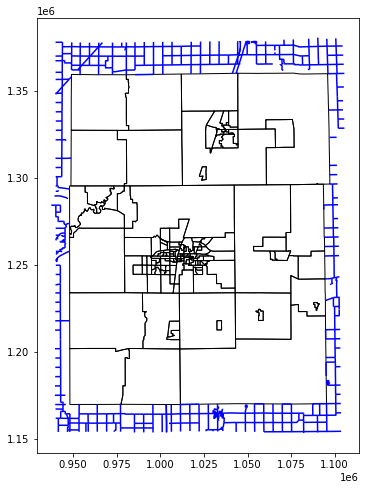

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,8))
bg_pop.plot(ax=ax,facecolor='none', edgecolor='k') # street blocks
SegmentID.loc[SegmentID['segment_id'].isin(misslist_1)].plot(ax=ax,color='blue') # missing segment records

**Deal with segments that have duplicate records**

In [11]:
print(streets_pop.shape[0])
print(len(set(streets_pop['segment_id'].values)))
if streets_pop.shape[0] == len(set(streets_pop['segment_id'].values)):
    print('All unique records')
else:
    print('Have {} records with same segment_id'.format(streets_pop.shape[0]-len(set(streets_pop['segment_id'].values))))

17522
15004
Have 2518 records with same segment_id


<AxesSubplot:>

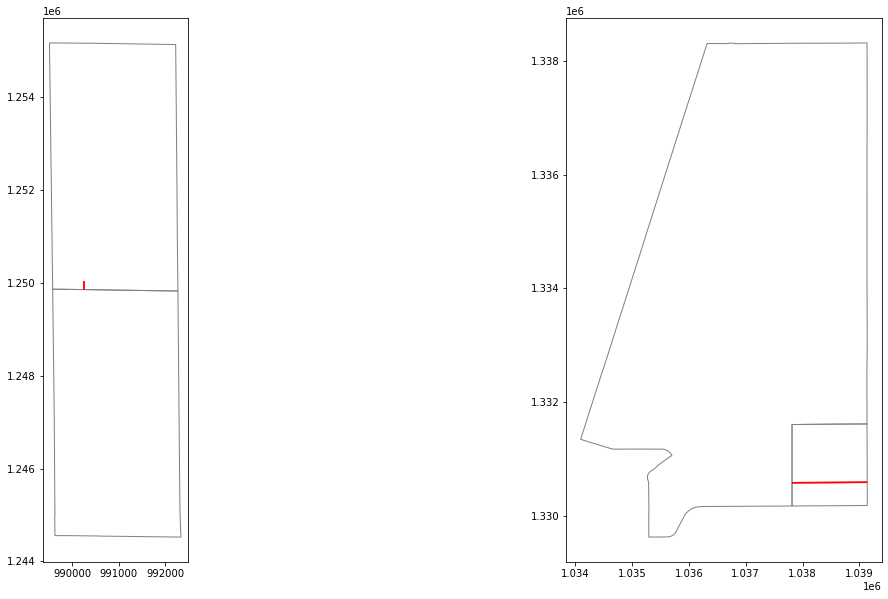

In [12]:
# Example_1: Attach more than one street block to a road segment
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
id1=1
id2=8248
bg_pop[bg_pop['GEOID'].isin(streets_pop[streets_pop['segment_id']==id1].GEOID)].plot(ax=ax1,facecolor='none', edgecolor='grey') # background 
streets_pop[streets_pop['segment_id']==id1].plot(ax=ax1,color='red')# duplicate segment records
bg_pop[bg_pop['GEOID'].isin(streets_pop[streets_pop['segment_id']==id2].GEOID)].plot(ax=ax2,facecolor='none', edgecolor='grey') # background 
streets_pop[streets_pop['segment_id']==id2].plot(ax=ax2,color='red')# duplicate segment records

In [13]:
streets_pop[streets_pop['segment_id']==1]

segment_id                                           geometry  index_right  \
3           1  LINESTRING (990250.010 1250037.162, 990247.945...           71   
3           1  LINESTRING (990250.010 1250037.162, 990247.945...           12   

          GEOID  Pop_den_2014  Pop_den_2015  Pop_den_2016  Pop_den_2017  \
3  170190012062    249.904814    283.095297    273.333390    253.809576   
3  170190012051    298.826539    285.243514    267.779626    246.434873   

   Pop_den_2018  
3    292.857204  
3    194.043207

In [14]:
print('Length in first street block is {}'.format(gpd.clip(SegmentID[SegmentID['segment_id']==1],bg_pop[bg_pop['GEOID']=='170190012062']).length.values[0]))
print('Length in second street block is {}'.format(gpd.clip(SegmentID[SegmentID['segment_id']==1],bg_pop[bg_pop['GEOID']=='170190012051']).length.values[0]))

Length in first street block is 1.0424573313902583
Length in second street block is 183.97086266465348


<AxesSubplot:>

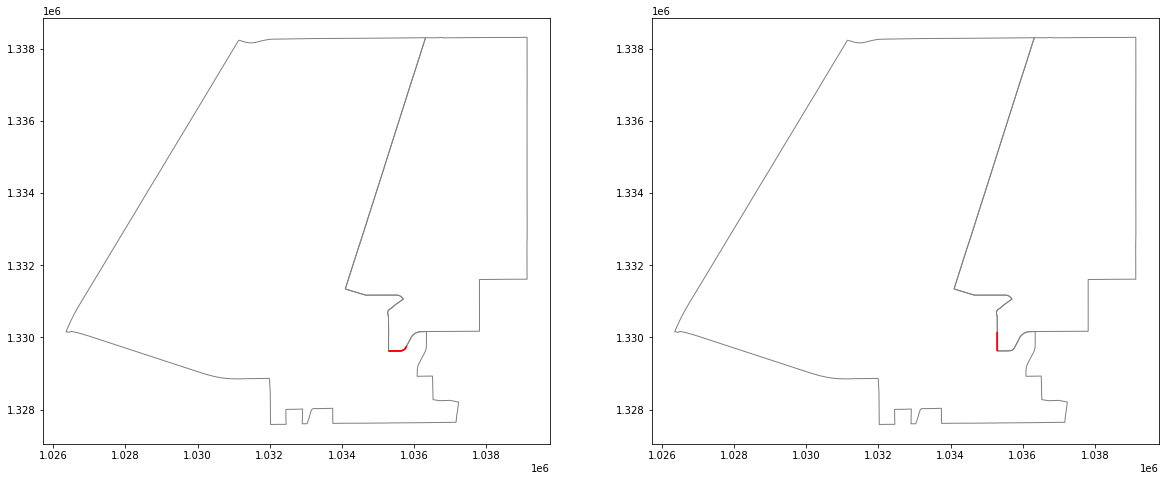

In [15]:
# Example_2: On the boundary
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
id1=8208
id2=8209
bg_pop[bg_pop['GEOID'].isin(streets_pop[streets_pop['segment_id']==id1].GEOID)].plot(ax=ax1,facecolor='none', edgecolor='grey') # background 
streets_pop[streets_pop['segment_id']==id1].plot(ax=ax1,color='red')# duplicate segment records
bg_pop[bg_pop['GEOID'].isin(streets_pop[streets_pop['segment_id']==id2].GEOID)].plot(ax=ax2,facecolor='none', edgecolor='grey') # background 
streets_pop[streets_pop['segment_id']==id2].plot(ax=ax2,color='red')# duplicate segment records

In [16]:
# Delete & replace clear records
streets_pop = rpl_dup_seg_rec(streets_pop,bg_pop,SegmentID)

All street segments have unique record now


In [17]:
streets_pop.shape

(15004, 9)

In [18]:
#with open('../data/interim/roadway/preprocessing/streets_pop_final.pkl', 'wb') as f:
#     pickle.dump(streets_pop, f)

with open(base_file_dir+'data/interim/roadway/preprocessing/streets_pop_final.pkl', 'rb') as f:
    streets_pop = pickle.load(f)

In [19]:
streets_pop.head()

segment_id                                           geometry  index_right  \
0       12673  LINESTRING (1009223.752 1257175.333, 1008902.7...           18   
1       12800  LINESTRING (1008903.910 1257002.373, 1008902.7...           18   
2       12801  LINESTRING (1008902.763 1257174.368, 1008901.6...           18   
3       12301  LINESTRING (1009381.145 1254591.956, 1009382.3...           18   
4       12302  LINESTRING (1009378.090 1254932.202, 1009381.1...           18   

          GEOID  Pop_den_2014  Pop_den_2015  Pop_den_2016  Pop_den_2017  \
0  170190110005    219.876714    195.051923    209.237518    191.505525   
1  170190110005    219.876714    195.051923    209.237518    191.505525   
2  170190110005    219.876714    195.051923    209.237518    191.505525   
3  170190110005    219.876714    195.051923    209.237518    191.505525   
4  170190110005    219.876714    195.051923    209.237518    191.505525   

   Pop_den_2018  
0    212.783916  
1    212.783916  
2    212.783916  
3    212.783916  
4    212.783916

## 4.2.6 Combine all temporal features
<a id='combine-all-temporal-features'></a>
[[back to top](#sections)]

In [20]:
with open(base_file_dir+'data/interim/roadway/preprocessing/roadway_temporal_2014_2018_final.pkl', 'rb') as f:
    roadway_temporal_2014_2018 = pickle.load(f)
roadway_temporal_2014_2018.loc[roadway_temporal_2014_2018['AADT_2014']<0,'AADT_2014']=roadway_temporal_2014_2018['AADT_2015']

with open(base_file_dir+'data/interim/roadway/preprocessing/hcv_temporal_2014_2018_final.pkl', 'rb') as f:
    hcv_temporal_2014_2018 = pickle.load(f)

with open(base_file_dir+'data/interim/roadway/preprocessing/crs_temporal_2014_2018_final.pkl', 'rb') as f:
    crs_temporal_2014_2018= pickle.load(f)

with open(base_file_dir+'data/interim/roadway/preprocessing/streets_pop_final.pkl', 'rb') as f:
    streets_pop = pickle.load(f)

In [21]:
streets_pop = fill_null_strs_pop(streets_pop)

In [22]:
streets_pop.head()

index  segment_id                                           geometry  \
0  12636           1  LINESTRING (990250.010 1250037.162, 990247.945...   
1   7035           2  LINESTRING (1018513.362 1265282.367, 1018626.8...   
2   5443           3  LINESTRING (1029766.300 1315986.300, 1029858.2...   
3   7209           4  LINESTRING (1004692.299 1213384.700, 1004753.5...   
4   7280           5  LINESTRING (1064665.653 1354535.077, 1064656.7...   

   index_right         GEOID  Pop_den_2014  Pop_den_2015  Pop_den_2016  \
0           12  170190012051    298.826539    285.243514    267.779626   
1            0  170190054021    142.023069    126.242728    151.885782   
2           28  170190104002      1.819458      1.783429      2.107689   
3          144  170190109004     21.937256     28.792649     34.276963   
4          122  170190104004      2.803419      2.781602      2.988859   

   Pop_den_2017  Pop_den_2018  
0    246.434873    194.043207  
1    157.803410    138.077984  
2      2.305848      2.702166  
3     36.333581     41.132355  
4      2.803419      2.727061

In [24]:
# (1) Merge AADT and HCV & (2) Populate missing heavy vehicle count numbers (HCV) with a percentage of the AADT (0.07).
hcv_share=0.07
roadway_temporal_volume = merge_aadt_hcv(roadway_temporal_2014_2018, hcv_temporal_2014_2018,hcv_share)

Heavy Vehicle Count (HCV) data merged into AADT data


In [26]:
roadway_temporal = merge_aadt_hcv_pc(roadway_temporal_volume, crs_temporal_2014_2018)

Pacement Condition (PC) data merged into AADT_HCV data


In [27]:
roadway_temporal_final = merge_aadt_hcv_pc_stspop(roadway_temporal,streets_pop)

Street Pop Density data merged into AADT_HCV_PC data


In [28]:
#with open('../data/interim/roadway/preprocessing/roadway_temporal_final.pkl', 'wb') as f:
#     pickle.dump(roadway_temporal_final, f)

In [29]:
with open(base_file_dir+'data/interim/roadway/preprocessing/roadway_temporal_final.pkl', 'rb') as f:
    roadway_temporal_final = pickle.load(f)

In [30]:
roadway_temporal_final.describe()

segment_id     AADT_2014     AADT_2015     AADT_2016     AADT_2017  \
count  12976.000000  12976.000000  12976.000000  12976.000000  12976.000000   
mean    8232.165151   1716.802250   1725.584541   1787.068203   1740.447981   
std     4595.224574   4148.909092   4115.066319   4271.027145   4188.964704   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%     4234.750000    577.000000    567.000000    557.000000    546.000000   
50%     8440.500000    577.000000    567.000000    557.000000    546.000000   
75%    12087.250000    577.000000    567.000000    557.000000    546.000000   
max    16090.000000  65450.000000  63000.000000  63150.000000  63100.000000   

          AADT_2018      HCV_2014      HCV_2015      HCV_2016      HCV_2017  \
count  12976.000000  12976.000000  12976.000000  12976.000000  12976.000000   
mean    1713.479501    163.367293    163.391030    178.830764    172.214473   
std     4117.588718    701.630742    688.829965    797.216087    758.703660   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      536.000000     40.000000     39.000000     38.000000     38.000000   
50%      536.000000     40.000000     39.000000     38.000000     38.000000   
75%      536.000000     40.000000     39.000000     38.000000     38.000000   
max    61166.000000   9700.000000   9275.000000  11037.000000  10450.000000   

           HCV_2018  Pop_den_2014  Pop_den_2015  Pop_den_2016  Pop_den_2017  \
count  12976.000000  12976.000000  12976.000000  12976.000000  12976.000000   
mean     168.409756    202.978499    207.365059    206.851187    201.656597   
std      751.508627    445.341546    477.075236    483.953551    482.903433   
min        0.000000      1.000000      1.000000      1.000000      1.000000   
25%       37.000000     11.000000     11.000000     11.000000     11.000000   
50%       37.000000     91.000000     97.000000     88.000000     94.000000   
75%       37.000000    268.000000    259.000000    263.000000    244.000000   
max    10366.000000   9019.000000   9797.000000  10315.000000  10459.000000   

       Pop_den_2018  
count  12976.000000  
mean     198.645037  
std      475.856496  
min        1.000000  
25%       10.000000  
50%       98.000000  
75%      247.000000  
max    10085.000000

In [31]:
roadway_temporal_final_nan=pd.DataFrame(roadway_temporal_final.isnull().sum())
roadway_temporal_final_nan['nan_share']=roadway_temporal_final_nan[0]/roadway_temporal_final.shape[0]*100
roadway_temporal_final_nan

0  nan_share
segment_id                    0   0.000000
AADT_2014                     0   0.000000
AADT_2015                     0   0.000000
AADT_2016                     0   0.000000
AADT_2017                     0   0.000000
AADT_2018                     0   0.000000
HCV_2014                      0   0.000000
HCV_2015                      0   0.000000
HCV_2016                      0   0.000000
HCV_2017                      0   0.000000
HCV_2018                      0   0.000000
Pop_den_2014                  0   0.000000
Pop_den_2015                  0   0.000000
Pop_den_2016                  0   0.000000
Pop_den_2017                  0   0.000000
Pop_den_2018                  0   0.000000
PC_2014                       0   0.000000
PC_2015                       0   0.000000
PC_2016                       0   0.000000
PC_2017                       0   0.000000
PC_2018                       0   0.000000
functional_classification   154   1.186806
pavement_condition         6012  46.331689

<a id='target-feature'></a>

# 4.3 Crash location and time (year)
<a id='crash-location-and-time'></a>
[[back to top](#sections)]

## 4.3.1 Project each crash to its road segment
<a id='project-each-crash-to-its-road-segment'></a>
[[back to top](#sections)]

In [4]:
with open(base_file_dir+'data/interim/roadway/data_source/streets.pkl', 'rb') as f:
    streets = pickle.load(f)

In [5]:
crashes_2014_2018=pd.read_csv(base_file_dir+"data/crashes_2014_2018.csv",low_memory=False)
crashes_2014_2018['Crash_Index']=crashes_2014_2018.index

In [6]:
# Project PCD roadway (sub)segments to epsg:3435
geo_SegmentID = geo_segmentid(streets)
# This function reproject crashes to epsg:3435
geo_crashes_2014_2018_repro = proj_crash(crashes_2014_2018)

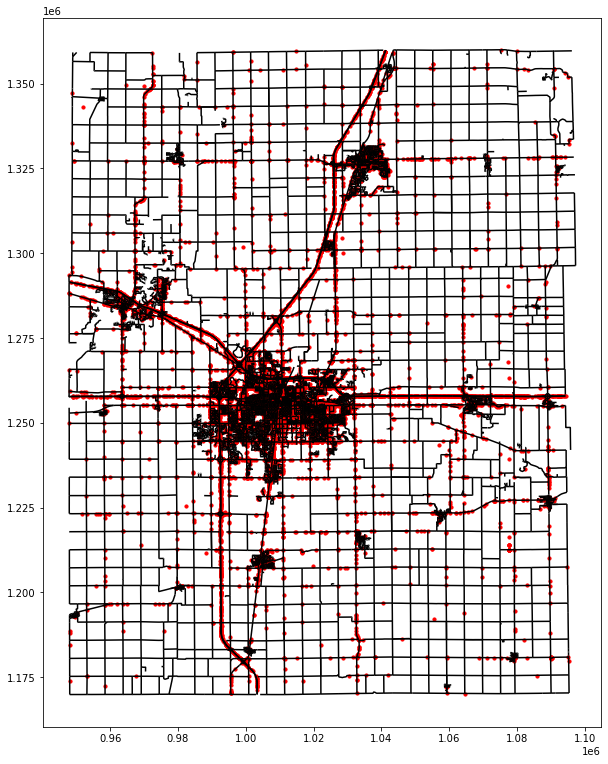

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 20))
ax.set_aspect('equal')
geo_crashes_2014_2018_repro.plot(ax=ax, marker='o', color='red', markersize=10)
geo_SegmentID.plot(ax=ax, color='black')
plt.show();

The assign_segment_to_crashes function achieves similar thing as Join Attributes by Nearest Tool in the Vector Tool toolbox in QGIS. This function was inspired by [this blog post](https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa). <mark>However, there are about 15% difference in the outputs compared with the QGIS output. For simplicity sake, we use QGIS results.</mark>  

In the Join Attributes by Nearst Tool, use the crash output from Chapter 2, section 2.1.2 as input layer 1 in (use long/lat as X/Y input when geocoding the crashes, with WGS84 as the projection system). Use PCD/street/segment layer as input layer 2. Set the max distance to be 100ft. Save outputs in folder data as crash_segment_qgis.csv.

In [8]:
# crash_segment=assign_segment_to_crashes (geo_crashes_2014_2018_repro,geo_SegmentID)
# A total number of 192 crashes were filtered out as non-segment crashes, using 100ft as the threshold. 
# crash_segment.to_csv('../data/crash_segment.csv')

crash_segment=pd.read_csv(base_file_dir+'data/crash_segment_qgis.csv')

In [9]:
crash_segment.head(5)

fid           ICN  CrashYear  CrashMonth  CrashDay  CrashHour  DayofWeek  \
0    1  201400252837         14          10         9         12   Thursday   
1    2  201400271924         14          10         6         14     Monday   
2    3  201400274386         14          10         8         21  Wednesday   
3    4  201400252968         14          10         7         17    Tuesday   
4    5  201400252971         14          10         5         13     Sunday   

           TypeofFirstCrash  TotalFatals  TotalInjured  ...  idot_aadt  \
0                  Rear End            0             1  ...     5850.0   
1  Sideswipe Same Direction            0             0  ...    14800.0   
2              Fixed Object            0             0  ...    23600.0   
3                   Turning            0             0  ...     1200.0   
4                     Angle            0             0  ...     2050.0   

   functional_classification  cross_name_start    cross_name_end    n  \
0             Minor Arterial    S Maplewood Dr   Bethany Park Dr  1.0   
1             Major Arterial    N Prospect Ave    N Highland Ave  1.0   
2                 Interstate  I-57 Turn Around  I-57 Turn Around  1.0   
3            Minor Collector      S Mattis Ave      Ridgeland Dr  1.0   
4       Local Road or Street          S New St           Pine St  1.0   

   distance     feature_x     feature_y     nearest_x     nearest_y  
0  0.251523  1.039142e+06  1.327671e+06  1.039142e+06  1.327671e+06  
1  4.485059  1.005314e+06  1.262067e+06  1.005316e+06  1.262071e+06  
2  7.158880  1.015542e+06  1.288684e+06  1.015548e+06  1.288680e+06  
3  9.522257  1.000150e+06  1.248542e+06  1.000150e+06  1.248532e+06  
4  4.870909  1.005937e+06  1.253638e+06  1.005936e+06  1.253633e+06  

[5 rows x 84 columns]

There are features in the PCD street segment layer with same geometry but different names for cartographic purposes. Filter these segments first.

In [10]:
crash_segment=crash_segment[crash_segment['overlap']=='P']

There are crashes that have been assigned to more than one segments. Identify and remove duplicate records.

In [11]:
print('Number of crashes that were assigned to more than one segments:', sum(crash_segment['ICN'].value_counts()>1))

Number of crashes that were assigned to more than one segments: 3


In [12]:
# Crashes that were assigned to more than one segment: 
crash_segment['ICN'].value_counts()[crash_segment['ICN'].value_counts()>1].index

Int64Index([201701029109, 201701176964, 201801032032], dtype='int64')

In [13]:
crash_segment[crash_segment['ICN']==201701029109].segment_id #remove record on segment 7362, index 12808

12808    7362.0
12809    7363.0
Name: segment_id, dtype: float64

In [14]:
crash_segment[crash_segment['ICN']==201701176964].segment_id #remove record on segment 1058, index 10922

10921    1057.0
10922    1058.0
Name: segment_id, dtype: float64

In [15]:
crash_segment[crash_segment['ICN']==201801032032].segment_id #remove record on segment 3831, index 13881

13881    3831.0
13882    3829.0
Name: segment_id, dtype: float64

In [16]:
crash_segment = crash_segment.drop(index=[12808,10922,13881])

In [17]:
# Recheck crashes that were assigned to more than one segment: 
crash_segment['ICN'].value_counts()[crash_segment['ICN'].value_counts()>1].index

Int64Index([], dtype='int64')

## 4.3.2 Summarize crashes per segment per year
<a id='summarize-crashes-per-segment-per-year'></a>
[[back to top](#sections)]

In [18]:
# Summarizes the number of crashes per segment for each year
target_14,target_15,target_16,target_17,target_18 = crash_by_seg_yr(crash_segment,geo_SegmentID)
# Merge all crashes together in time (year) order
target = merge_all_target(target_14, target_15,target_16,target_17,target_18)

In [19]:
with open('../data/interim/roadway/preprocessing/target.pkl', 'wb') as f:
    pickle.dump(target, f)
    
# with open(base_file_dir+'data/interim/roadway/preprocessing/target.pkl', 'rb') as f:
#     target = pickle.load(f)

<a id='all-features'></a>

# 4.4 Combine all features
<a id='combine-all-features'></a>
[[back to top](#sections)]

In [20]:
with open(base_file_dir+'data/interim/roadway/preprocessing/roadway_static_full_final.pkl', 'rb') as f:
    roadway_static_full = pickle.load(f)
with open (base_file_dir+'data/interim/roadway/preprocessing/roadway_temporal_final.pkl', 'rb') as f:
    roadway_temporal_final = pickle.load(f)
with open (base_file_dir+'data/interim/roadway/preprocessing/target.pkl', 'rb') as f:
     target = pickle.load(f)

The roadway static and temporal geometry network database is smaller than the target network database (12148 and 12976 segments vs 14941 segments). This is due to the limited geometry data availability.   
  
Significant efforts have been made to populate some geometry values for segments (e.g. AADT and pavement condition, etc.) by applying the average values from roadways of similar functional class. However, other attributes (e.g. shoulder width, median type, etc.) cannot be populated in this manner. Therefore, losing some segments, and as a result, losing some crashes happed on these segments is not avoidable.  
  
CUUATS staff believes it's more important to preserve the integrity of the roadway geometry values, and build models upon these geometry values, than trying to include every roadway segments with inaccurate geometry values. 

In [21]:
print(roadway_static_full.shape) 
print(roadway_temporal_final.shape)
print(target.segment_id.nunique())

(12148, 69)
(12976, 23)
14941


In [22]:
# Preparation for merging all related data
# Reshapes static feature table to a long table
df_static = cmb_static_full_by_yr(roadway_static_full)
# Reshape temporal feature table to long table
df_temporal = cmb_tmp_fnl_by_yr(roadway_temporal_final)
# Rename column name 
target=target.rename(columns={'ICN':'Crashes'})

Use static feature dataframe segment_index as the base for the final complete dataframe.

In [23]:
df = merge_stat_tmp_tgt(df_static,df_temporal,target)

Static feature dataframe segment_id is used as the base for the final complete dataframe


Segments in the df database needs to be filtered with overlap= 'P' to remove duplicated geometry records. Prior to this step, three segments in the database needs to be updated with overlap='S' as they have been miscoded.  
The segment_id of these three segments are 1058, 6078, and 6985. 

In [25]:
df[df.segment_id==1058].overlap='S'
df[df.segment_id==6078].overlap='S'
df[df.segment_id==6985].overlap='S'

In [26]:
df=df[df.overlap=='P']

In [27]:
df.columns

Index(['segment_id', 'overlap', 'st_length', 'curve_ratio', 'one_way',
       'bicycle_facility_width', 'bicycle_path_category',
       'bicycle_buffer_width', 'bicycle_buffer_type', 'bicycle_path_type',
       'bicycle_approach_alignment', 'bus_trips_total', 'crossing_aadt',
       'crossing_functional_classification', 'crossing_speed',
       'functional_classification', 'intersection_control_type',
       'lane_configuration', 'max_lanes_crossed', 'parking_lane_width',
       'marked_center_line', 'posted_speed', 'railroad_crossing_type',
       'right_turn_length', 'road_sign_type', 'sidewalk_buffer_width',
       'sidewalk_condition_score', 'sidewalk_width', 'sidewalk_buffer_type',
       'total_lanes', 'in_urbanized_area', 'volume_capacity',
       'overall_landuse', 'ACC_CNTL', 'I_SHD1_TYP', 'I_SHD1_WTH', 'I_SHD2_TYP',
       'I_SHD2_WTH', 'LN_WTH', 'LNS', 'MED_TYP', 'MED_WTH', 'SURF_TYP',
       'SURF_WTH', 'O_SHD1_TYP', 'O_SHD1_WTH', 'O_SHD2_TYP', 'O_SHD2_WTH',
       'OP_1_2_

In [28]:
df=df.astype({'geometry': 'object'})
df=df.dropna(subset=['PC', 'Pop_den','HCV','AADT'])
df.isnull().sum().sort_values(ascending=False)

segment_id                  0
O_SHD2_WTH                  0
I_SHD1_TYP                  0
I_SHD1_WTH                  0
I_SHD2_TYP                  0
                           ..
sidewalk_condition_score    0
sidewalk_width              0
sidewalk_buffer_type        0
total_lanes                 0
Crashes                     0
Length: 63, dtype: int64

In [30]:
#with open('../data/interim/roadway/preprocessing/df_final.pkl', 'wb') as f:
#    pickle.dump(df, f)
#with open(base_file_dir+'data/interim/roadway/preprocessing/df_final.pkl', 'rb') as f:
#    df = pickle.load(f)

# 4.5 Explore data distribution
<a id='explore-data-distribution'></a>
[[back to top](#sections)]

In [1]:
# See 4A_Data_Distribution.ipynb

<a id='negative-sampling'></a>